# Використання існуючої моделі

Для експерементів використаємо модель ResNet18

Як датасет використаємо частину датасету Intel Image Classification, а саме:

- Будівлі
- Гори
- Ліса


**Імпортируємо необхідні бібліотеки та трансформуємо наш датасет під налаштування моделі**

In [114]:
import torch
import os
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from torchvision.models import ResNet18_Weights
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
train_dataset = torchvision.datasets.ImageFolder(
    root='../dataset_Andrii/train/',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root='../dataset_Andrii/test/',
    transform=test_transform)

# Первинний аналіз даних

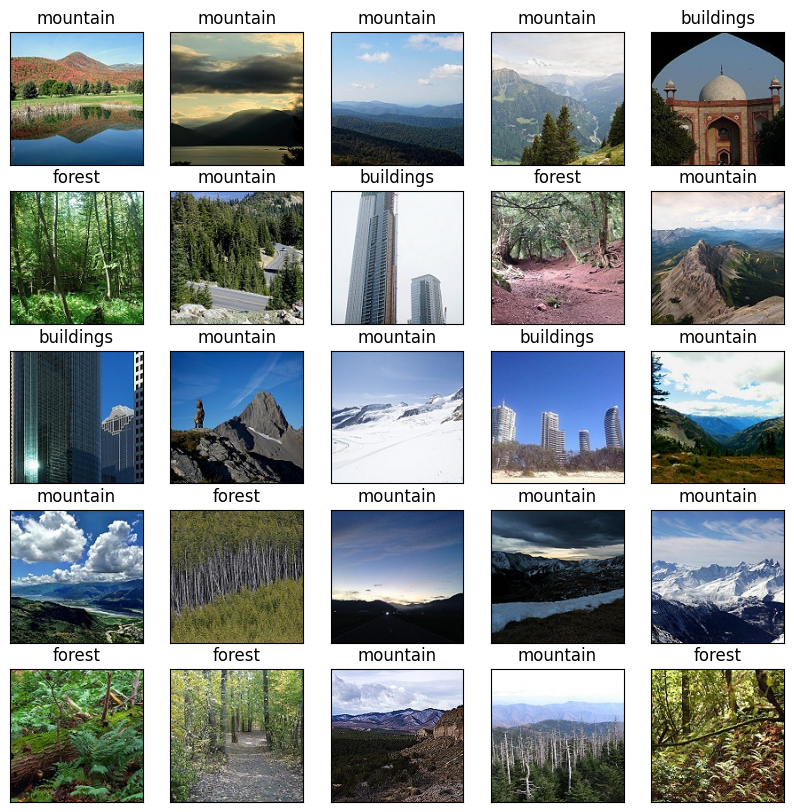

In [13]:
fig = plt.figure(figsize=(10, 10))
visualize_dataset = torchvision.datasets.ImageFolder(root='../dataset_Andrii/train/')
rows, columns = 5, 5
rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))

images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")

Як можемо бачити з візуалізаціїї частини нашого датасету, картинки доволі різні. 

Проте маємо деякі схожості:

- Існують лісисті гори. Тобто картинка класифікована як "Гори", але також має і ліс, що може зменшити точність моделі.
- В більшій своїй частині, будівлі не схожі на інші класи. Але можуть бути схожості за кольором (картинки 2х3 та 3х3). Навряд це буде мати вагомий вплив на якість моделі.
- Ліси не завжи ростуть на рівній поверхні (картинка 2х4), є ймовірність, що модель сприйме це як "Гори".

In [14]:
# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for 
num_epochs = 15

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model = models.resnet18(pretrained=True)
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Training only the last layer, the other layers are freezed
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

num_ftrs = 512


In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"{preds = }")
                # print(f"{labels.data = }")
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}

model = model.to(device)
optimizer_ft = optim.Adam(params=model.parameters())

In [17]:
criterion = nn.CrossEntropyLoss()

model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.4174 Acc: 0.8818
val Loss: 0.1059 Acc: 0.9913

Epoch 1/14
----------
train Loss: 0.0917 Acc: 0.9868
val Loss: 0.0614 Acc: 0.9939

Epoch 2/14
----------
train Loss: 0.0660 Acc: 0.9879
val Loss: 0.0467 Acc: 0.9931

Epoch 3/14
----------
train Loss: 0.0518 Acc: 0.9896
val Loss: 0.0379 Acc: 0.9931

Epoch 4/14
----------
train Loss: 0.0438 Acc: 0.9909
val Loss: 0.0341 Acc: 0.9939

Epoch 5/14
----------
train Loss: 0.0403 Acc: 0.9918
val Loss: 0.0297 Acc: 0.9939

Epoch 6/14
----------
train Loss: 0.0365 Acc: 0.9921
val Loss: 0.0296 Acc: 0.9922

Epoch 7/14
----------
train Loss: 0.0348 Acc: 0.9910
val Loss: 0.0257 Acc: 0.9939

Epoch 8/14
----------
train Loss: 0.0303 Acc: 0.9923
val Loss: 0.0234 Acc: 0.9948

Epoch 9/14
----------
train Loss: 0.0302 Acc: 0.9934
val Loss: 0.0237 Acc: 0.9948

Epoch 10/14
----------
train Loss: 0.0294 Acc: 0.9919
val Loss: 0.0220 Acc: 0.9948

Epoch 11/14
----------
train Loss: 0.0288 Acc: 0.9929
val Loss: 0.0207 Acc: 0.9931

Ep

# Результати експеременту

Навіть на середньому датасеті в приблизно 5 тисяч картинок для тренування, модель це робить доволі повільно, що показує чому наявність Cuda важлива в ML.

Незважаючи на певні схожості між класами, модель натренувалась якісно і на тестовому сеті впоралась на 99%.

Побудуємо графіки точності та похибки протягом усіх епох.

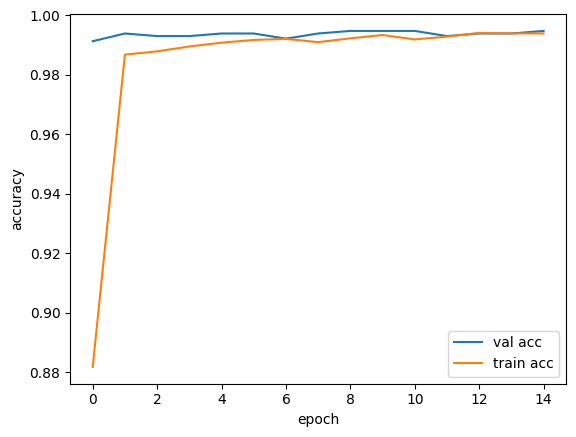

In [19]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

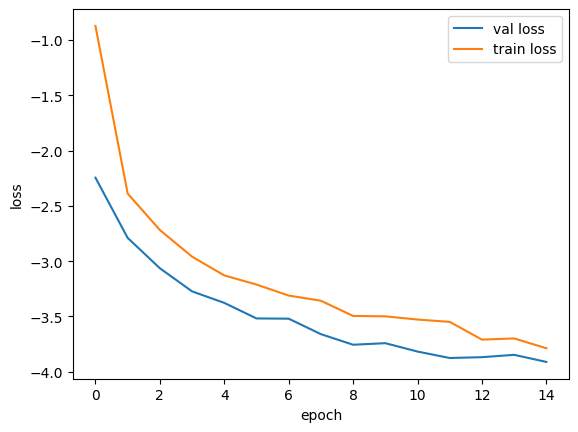

In [20]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

# Експеремент другий

Тепер спробуємо той самий датасет на простій нейроній мережі, яку ми самі і зробимо.

In [127]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        output = self.fc3(x)

        return output

def train(model, device, train_loader, optimizer, epoch, loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def get_mean_std(data_loader):
    sum_, squared_sum, batches = 0, 0, 0
    for data, _ in data_loader:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim=([0, 2, 3]))
        batches += 1
    
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5
    return mean, std

In [81]:
train_transform = transforms.Compose([
                       transforms.Resize(64),
                       transforms.RandomCrop(64),
                       transforms.ToTensor()
                   ])


test_transform = transforms.Compose([
                       transforms.Resize(64),
                       transforms.RandomCrop(64),
                       transforms.ToTensor()
                   ])

train_dataset = torchvision.datasets.ImageFolder(
        root='../dataset_Andrii/train/',
        transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
        root='../dataset_Andrii/test/',
        transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3)

In [82]:
mean, std = get_mean_std(train_loader)
mean, std

(tensor([0.4079, 0.4349, 0.4110]), tensor([0.2468, 0.2476, 0.2879]))

In [83]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [84]:
train_transform

Compose(
    RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4079, 0.4349, 0.4110]), std=tensor([0.2468, 0.2476, 0.2879]))
)

In [85]:
test_transform

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=tensor([0.4079, 0.4349, 0.4110]), std=tensor([0.2468, 0.2476, 0.2879]))
)

In [88]:
train_datasets = datasets.ImageFolder(os.path.join('../dataset_Andrii/train/'),
                                      transform=train_transform)
test_datasets = datasets.ImageFolder(os.path.join('../dataset_Andrii/test/'),
                                    transform=test_transform)

In [129]:
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True,
                                                num_workers=2, pin_memory=True)

test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=64,
                                               num_workers=2, pin_memory=True)

In [94]:
CUDA = torch.cuda.is_available()
CUDA

False

In [130]:
def main():

    torch.manual_seed(1337)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    epochs = 10

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(1, epochs + 1):
        train(model, device, train_dataloaders, optimizer, epoch, loss_fn)
        test(model, device, test_dataloaders, loss_fn)
        scheduler.step()

    # torch.save(model.state_dict(), "mnist_cnn.pt")
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(model)
    print(summary(model, input_size=(3, 64, 64)))


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/5465 (0%)]	Loss: 1.114678

Test set: Average loss: 0.0038, Accuracy: 1057/1154 (92%)

Train Epoch: 2 [0/5465 (0%)]	Loss: 0.426134

Test set: Average loss: 0.0051, Accuracy: 990/1154 (86%)

Train Epoch: 3 [0/5465 (0%)]	Loss: 0.343603

Test set: Average loss: 0.0028, Accuracy: 1070/1154 (93%)

Train Epoch: 4 [0/5465 (0%)]	Loss: 0.263305

Test set: Average loss: 0.0023, Accuracy: 1094/1154 (95%)

Train Epoch: 5 [0/5465 (0%)]	Loss: 0.262635

Test set: Average loss: 0.0021, Accuracy: 1104/1154 (96%)

Train Epoch: 6 [0/5465 (0%)]	Loss: 0.174157

Test set: Average loss: 0.0020, Accuracy: 1108/1154 (96%)

Train Epoch: 7 [0/5465 (0%)]	Loss: 0.320399

Test set: Average loss: 0.0019, Accuracy: 1110/1154 (96%)

Train Epoch: 8 [0/5465 (0%)]	Loss: 0.165422

Test set: Average loss: 0.0020, Accuracy: 1107/1154 (96%)

Train Epoch: 9 [0/5465 (0%)]	Loss: 0.185342

Test set: Average loss: 0.0019, Accuracy: 1108/1154 (96%)

Train Epoch: 10 [0/5465 (0%)]	Loss: 0.168879

Test set: Average l

# Результати

Як бачимо, проста нейрона мережа виконує цю задачу добре, проте, трохи гірше за попередню модель.

Різниця може бути саме через недоліки датасету (описані вище) та/або недостатньою складністю нейронки.

Загалом, для конкретного датасету, точність 96% є дуже гарним результатом.